# NBA Winner Classifier

## Imports

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_winner_clf as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy

## Setup

In [201]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 60 seconds


### Utils functions

In [202]:
def filter_from(items, cond):
    return list(filter(cond, items))

In [203]:
def del_result_by(exp_name):
    global results_total
    results_total = filter_from(results_total, lambda i: i[0] != exp_name)
    utils_exp.exp_results = filter_from(utils_exp.exp_results, lambda i: i['exp_name'] != exp_name)

In [204]:
def get_result_by(exp_name):
    global results_total
    return next((x for x in results_total if x[0] == exp_name), None)

In [25]:
#del_result_by('reg_1_season')
#utils_exp.exp_results
#utils.deserialize_object(f'result_totals', [])

In [205]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [206]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.lineplot(
        data=results_df,
        x="season_test", y="balanced_accuracy", hue="model", style="model",
        markers=True, dashes=False)
    a.set_title(
        f"{experiment_name}-balanced_accuracy")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [207]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [208]:
metrics = ['precision', 'balanced_accuracy', 'roc_auc']

def print_prettier_exp_results(exp_name, metric='roc_auc'):
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std']]
    return ba_df[ba_df.exp_name == exp_name].sort_values(by=[f"{metric}_mean"], ascending=False)

## Load Dataset

In [209]:
season_games = sg.load_season_games_dataset()

## Dataset


In [31]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [210]:
df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

In [211]:
print(df.shape)
df = df.dropna()
print(df.isnull().sum().sum())
print(df.shape)

(9599, 261)
0
(9461, 261)


## Experiments

### Setup

In [212]:
exp_prefix = "clf_"
exp_group_name = "clf_experiments"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = []
TARGET = "HOME_WINS"
exp_X_columns = model_config.X_COLS
exp_y_columns = model_config.Y_CLF_COL

models = utils_exp.get_clf_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

### Feature selection

In [213]:
def dict_to_list(d):
    dictlist = []
    for key, value in d.items():
        temp = [key,value]
        dictlist.append(temp)
    return pd.DataFrame(data=dictlist)

In [222]:
# instantiate random forest
from collections import defaultdict

## RandomForest
model = models[4][1]

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
folds_selected_features = defaultdict(int)
boruta_selector = BorutaPy(model, n_estimators = 200, random_state = 0)
list_selected_features = []
for train_idx, test_idx in folds[:]:    
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    y_true = y_test
    # fit boruta
    boruta_selector.fit(np.array(X_train), np.array(y_train))
    boruta_ranking = boruta_selector.ranking_
    selected_features = np.array(exp_X_columns)[boruta_ranking <= 2]
    list_selected_features.append(selected_features)
    for f in selected_features:
        folds_selected_features[f]+=1
#dict_to_list(folds_selected_features)
# # store results
# boruta_ranking = boruta_selector.ranking_
# selected_features = np.array(feature_names)[boruta_ranking <= 2]

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

In [223]:
f_df = dict_to_list(folds_selected_features)

In [224]:
f_df.sort_values(by=[1, 0], ascending=False)
#f_df[f_df[1] > 2]
final_selected_features = list(f_df[0].unique())

,0,1
13,PLUS_MINUS_MEAN_AWAY,7
10,HOME_PLUS_MINUS_ML10,7
9,HOME_PLUS_MINUS_MEAN,7
8,HOME_PLUS_MINUS_L10,7
4,HOME_FG_PCT_MEAN,7
3,HOME_FG3_PCT,7
17,W_L_CUM_HOME,6
14,PLUS_MINUS_MEAN_HOME,6
12,PLUS_MINUS_L10_HOME,6
6,HOME_FT_PCT,6


In [247]:
best_boruta = list_selected_features[3]
sorted(best_boruta)
best_boruta

['FG_PCT_MEAN_AWAY',
 'FG_PCT_MEAN_HOME',
 'FT_PCT_ML10_AWAY',
 'HOME_FG3_PCT',
 'HOME_FG_PCT_L10',
 'HOME_FG_PCT_MEAN',
 'HOME_FT_PCT',
 'HOME_FT_PCT_ML10',
 'HOME_PLUS_MINUS_L10',
 'HOME_PLUS_MINUS_MEAN',
 'HOME_PLUS_MINUS_ML10',
 'PLUS_MINUS_L10_AWAY',
 'PLUS_MINUS_L10_HOME',
 'PLUS_MINUS_MEAN_AWAY',
 'PLUS_MINUS_MEAN_HOME',
 'W_L_CUM_AWAY',
 'W_L_CUM_HOME']

array(['FG_PCT_MEAN_AWAY', 'FG_PCT_MEAN_HOME', 'FT_PCT_ML10_AWAY',
       'HOME_FG3_PCT', 'HOME_FG_PCT_L10', 'HOME_FG_PCT_MEAN',
       'HOME_FT_PCT', 'HOME_FT_PCT_ML10', 'HOME_PLUS_MINUS_L10',
       'HOME_PLUS_MINUS_MEAN', 'HOME_PLUS_MINUS_ML10',
       'PLUS_MINUS_L10_AWAY', 'PLUS_MINUS_L10_HOME',
       'PLUS_MINUS_MEAN_AWAY', 'PLUS_MINUS_MEAN_HOME', 'W_L_CUM_AWAY',
       'W_L_CUM_HOME'], dtype='<U20')

#### Test best features

In [225]:
#[x for x in exp_X_columns if x not in final_selected_features]
X_boruta = df_sscv[final_selected_features]
y_boruta = df_sscv[TARGET]

experiment_name = f"{exp_prefix}2_seasons_boruta"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)


params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name, metric='precision')

Running experiment clf_2_seasons_boruta
Done


,exp_name,model,precision_mean,precision_std
3,clf_2_seasons_boruta,SVM,0.759779,0.015470
0,clf_2_seasons_boruta,LR,0.759003,0.014059
4,clf_2_seasons_boruta,RF,0.749202,0.010102
5,clf_2_seasons_boruta,XGB,0.747632,0.009149
6,clf_2_seasons_boruta,LGB,0.744206,0.009400
2,clf_2_seasons_boruta,DT,0.705247,0.009921
1,clf_2_seasons_boruta,KNN,0.683868,0.022084


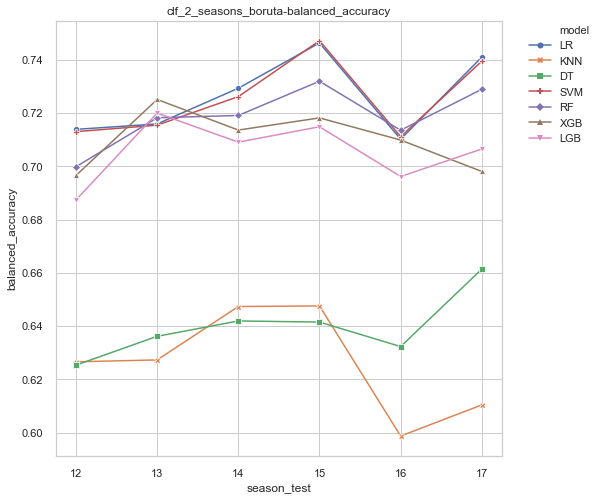

In [226]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,8))

#### Test specific best feature set

In [239]:
for idx, features in enumerate(list_selected_features):
    X_boruta = df_sscv[features]
    y_boruta = df_sscv[TARGET]

    experiment_name = f"{exp_prefix}2_seasons_boruta_specific_{idx}"
    del_result_by(experiment_name)
    folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)

    params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
    names, results = utils_exp.run_experiment(*params)
    results_total.append((experiment_name, results))
    #print_prettier_exp_results(experiment_name, metric='precision')

Running experiment clf_2_seasons_boruta_specific_0
Done
Running experiment clf_2_seasons_boruta_specific_1
Done
Running experiment clf_2_seasons_boruta_specific_2
Done
Running experiment clf_2_seasons_boruta_specific_3
Done
Running experiment clf_2_seasons_boruta_specific_4
Done
Running experiment clf_2_seasons_boruta_specific_5
Done
Running experiment clf_2_seasons_boruta_specific_6
Done


#### Test custom best feature set

In [254]:
X_COLS_BEST_BORUTA = ['FG_PCT_MEAN_AWAY',
                      'FG_PCT_MEAN_HOME',
                      'FT_PCT_ML10_AWAY',
                      'HOME_FG3_PCT',
                      'HOME_FG_PCT_L10',
                      'HOME_FG_PCT_MEAN',
                      'HOME_FT_PCT',
                      'HOME_FT_PCT_ML10',
                      'HOME_PLUS_MINUS_L10',
                      'HOME_PLUS_MINUS_MEAN',
                      'HOME_PLUS_MINUS_ML10',
                      'PLUS_MINUS_L10_AWAY',
                      'PLUS_MINUS_L10_HOME',
                      'PLUS_MINUS_MEAN_AWAY',
                      'PLUS_MINUS_MEAN_HOME',
                      'W_L_CUM_AWAY',
                      'W_L_CUM_HOME']
X_boruta = df_sscv[X_COLS_BEST_BORUTA]
y_boruta = df_sscv[TARGET]

experiment_name = f"{exp_prefix}2_seasons_boruta_custom"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)

params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))
print_prettier_exp_results(experiment_name, metric='precision')

Running experiment clf_2_seasons_boruta_custom
Done


,exp_name,model,precision_mean,precision_std
73,clf_2_seasons_boruta_custom,SVM,0.760366,0.011854
70,clf_2_seasons_boruta_custom,LR,0.760026,0.011737
74,clf_2_seasons_boruta_custom,RF,0.755667,0.010853
75,clf_2_seasons_boruta_custom,XGB,0.748373,0.005121
76,clf_2_seasons_boruta_custom,LGB,0.743551,0.005716
72,clf_2_seasons_boruta_custom,DT,0.697575,0.008015
71,clf_2_seasons_boruta_custom,KNN,0.684097,0.016000


### Experiment using 1 season

In [197]:
experiment_name = f"{exp_prefix}1_season"

In [198]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_1_season
Done


,exp_name,model,roc_auc_mean,roc_auc_std
3,clf_1_season,SVM,0.709101,0.012540
0,clf_1_season,LR,0.709017,0.012937
6,clf_1_season,LGB,0.703240,0.014409
5,clf_1_season,XGB,0.700982,0.011990
4,clf_1_season,RF,0.698885,0.012036
2,clf_1_season,DT,0.628615,0.016042
1,clf_1_season,KNN,0.625190,0.021665


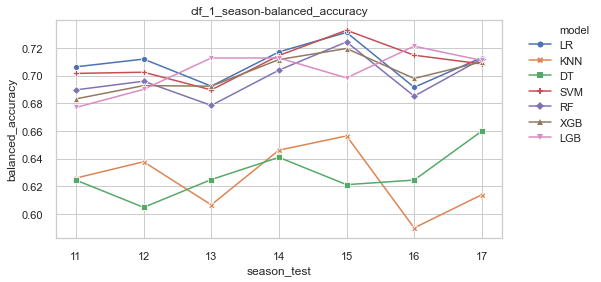

In [119]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment using StandardScaler

In [120]:
experiment_name = f"{exp_prefix}scaled_data"

In [121]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, model_config.X_COLS)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_scaled_data
Done


,exp_name,model,roc_auc_mean,roc_auc_std
7,clf_scaled_data,LR,0.711731,0.012925
10,clf_scaled_data,SVM,0.705660,0.013012
13,clf_scaled_data,LGB,0.702530,0.015683
12,clf_scaled_data,XGB,0.700667,0.011905
11,clf_scaled_data,RF,0.695711,0.019093
8,clf_scaled_data,KNN,0.640985,0.018080
9,clf_scaled_data,DT,0.628106,0.016284


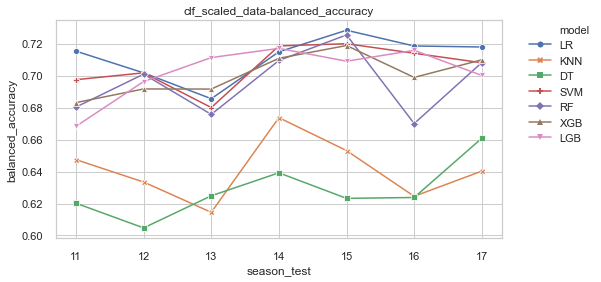

In [122]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))


### Experiment using MinMaxScaler

In [123]:
experiment_name = f"{exp_prefix}minmax_data"

In [124]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, model_config.X_COLS)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_minmax_data
Done


,exp_name,model,roc_auc_mean,roc_auc_std
17,clf_minmax_data,SVM,0.714386,0.012058
14,clf_minmax_data,LR,0.712034,0.008505
20,clf_minmax_data,LGB,0.703665,0.009476
19,clf_minmax_data,XGB,0.701012,0.012210
18,clf_minmax_data,RF,0.698326,0.015445
15,clf_minmax_data,KNN,0.648501,0.015518
16,clf_minmax_data,DT,0.628752,0.016135


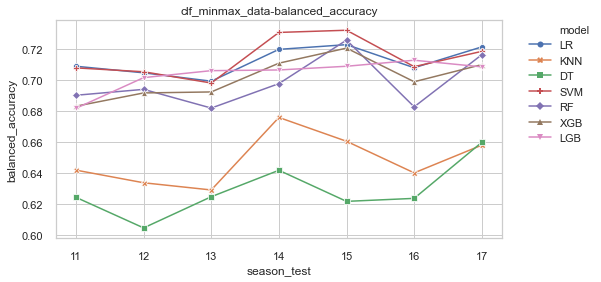

In [125]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment: train: 2s; test: 1s

In [126]:
experiment_name = f"{exp_prefix}2_seasons"

In [127]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons
Done


,exp_name,model,roc_auc_mean,roc_auc_std
21,clf_2_seasons,LR,0.723442,0.010121
24,clf_2_seasons,SVM,0.720484,0.013413
27,clf_2_seasons,LGB,0.714873,0.010690
26,clf_2_seasons,XGB,0.711581,0.008815
25,clf_2_seasons,RF,0.704222,0.010774
23,clf_2_seasons,DT,0.639275,0.018521
22,clf_2_seasons,KNN,0.623980,0.010725


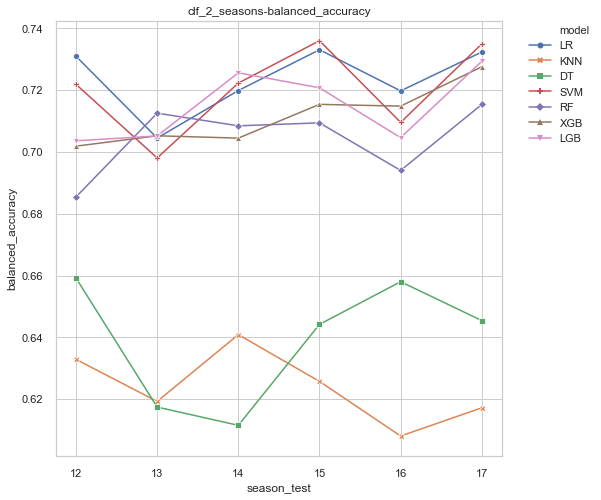

In [128]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,8))

### Experiment: train: 3s; test: 1s

In [129]:
experiment_name = f"{exp_prefix}3_seasons"

In [130]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3_seasons
Done


,exp_name,model,roc_auc_mean,roc_auc_std
34,clf_3_seasons,LGB,0.720076,0.006162
31,clf_3_seasons,SVM,0.719990,0.009980
28,clf_3_seasons,LR,0.719334,0.010428
33,clf_3_seasons,XGB,0.715202,0.007046
32,clf_3_seasons,RF,0.707995,0.013877
30,clf_3_seasons,DT,0.636390,0.018628
29,clf_3_seasons,KNN,0.628096,0.014454


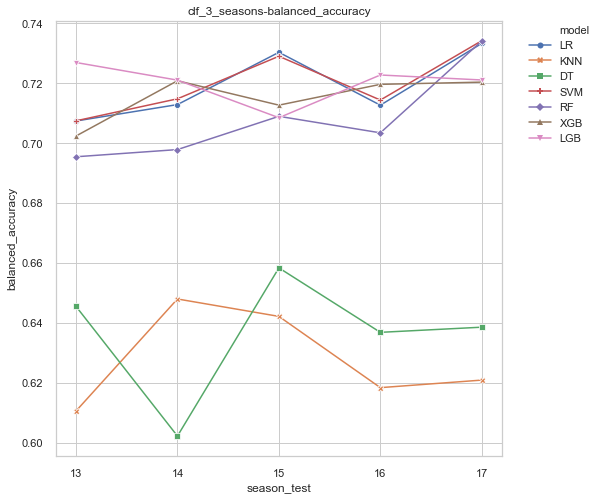

In [131]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,8))

### Experiment train: 3q ; test: 1q

In [132]:
experiment_name = f"{exp_prefix}3q_1q"

In [133]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3q_1q
Done


,exp_name,model,roc_auc_mean,roc_auc_std
38,clf_3q_1q,SVM,0.701302,0.026830
35,clf_3q_1q,LR,0.700641,0.023448
41,clf_3q_1q,LGB,0.700597,0.026585
40,clf_3q_1q,XGB,0.697485,0.021658
39,clf_3q_1q,RF,0.689731,0.021535
37,clf_3q_1q,DT,0.642057,0.032957
36,clf_3q_1q,KNN,0.630788,0.024962


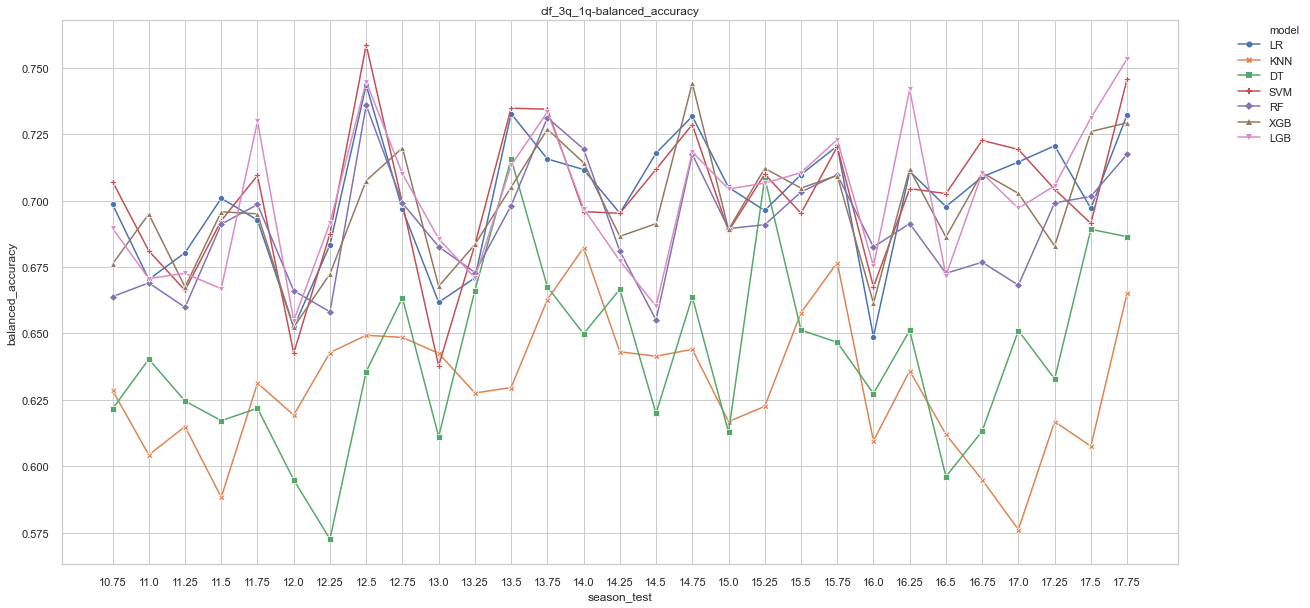

In [134]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(20, 10))

### Experiment train: 4q ; test: 2q

In [135]:
experiment_name = f"{exp_prefix}4q_2q"

In [136]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_4q_2q
Done


,exp_name,model,roc_auc_mean,roc_auc_std
42,clf_4q_2q,LR,0.711927,0.014178
45,clf_4q_2q,SVM,0.711630,0.015226
47,clf_4q_2q,XGB,0.705823,0.017220
48,clf_4q_2q,LGB,0.704875,0.019332
46,clf_4q_2q,RF,0.694828,0.017203
44,clf_4q_2q,DT,0.633617,0.022984
43,clf_4q_2q,KNN,0.626274,0.023710


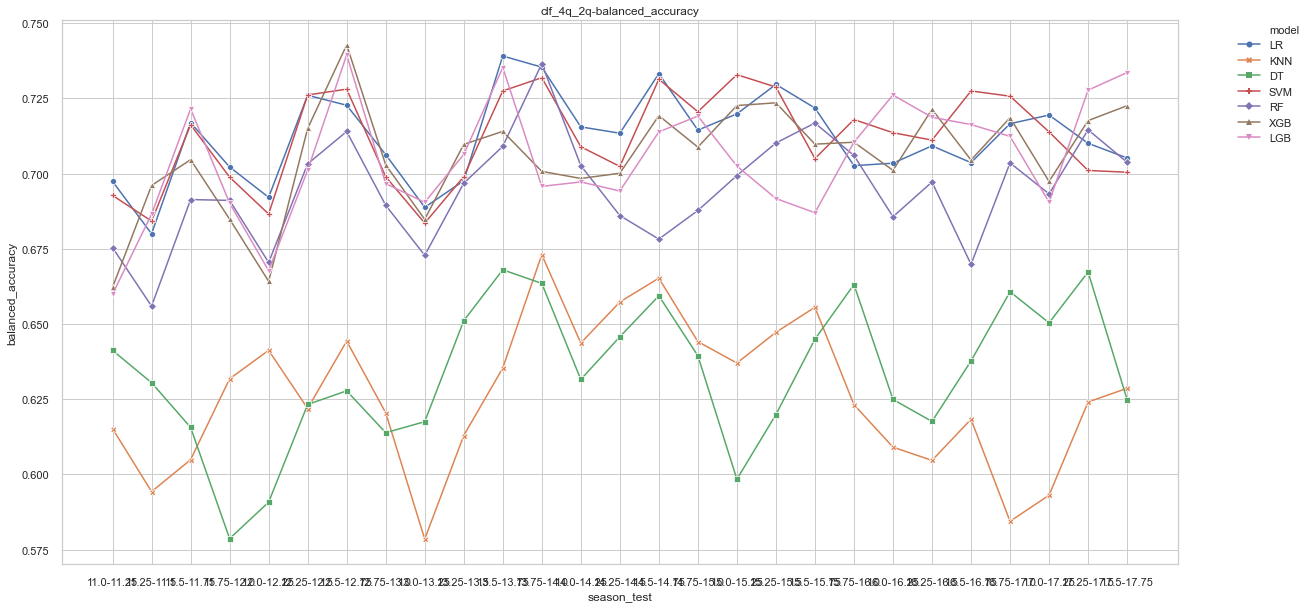

In [137]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(20,10))

### Experiment remove first 1q ; train: 2q ; test: 1q

En este experimento se eliminara el primer cuarto de cada temporada, y se entrenara el modelo con los 2 siguientes cuartos, y como test 1 cuarto de temporada. La ventana deslisante sera de 1 cuarto.

In [138]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

In [139]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=1, skip=[0.25])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_r1q_2q_1q
Done


,exp_name,model,roc_auc_mean,roc_auc_std
52,clf_r1q_2q_1q,SVM,0.704339,0.026106
55,clf_r1q_2q_1q,LGB,0.702335,0.027581
54,clf_r1q_2q_1q,XGB,0.700957,0.020635
49,clf_r1q_2q_1q,LR,0.699784,0.025921
53,clf_r1q_2q_1q,RF,0.691912,0.024475
51,clf_r1q_2q_1q,DT,0.641324,0.032264
50,clf_r1q_2q_1q,KNN,0.624460,0.029286


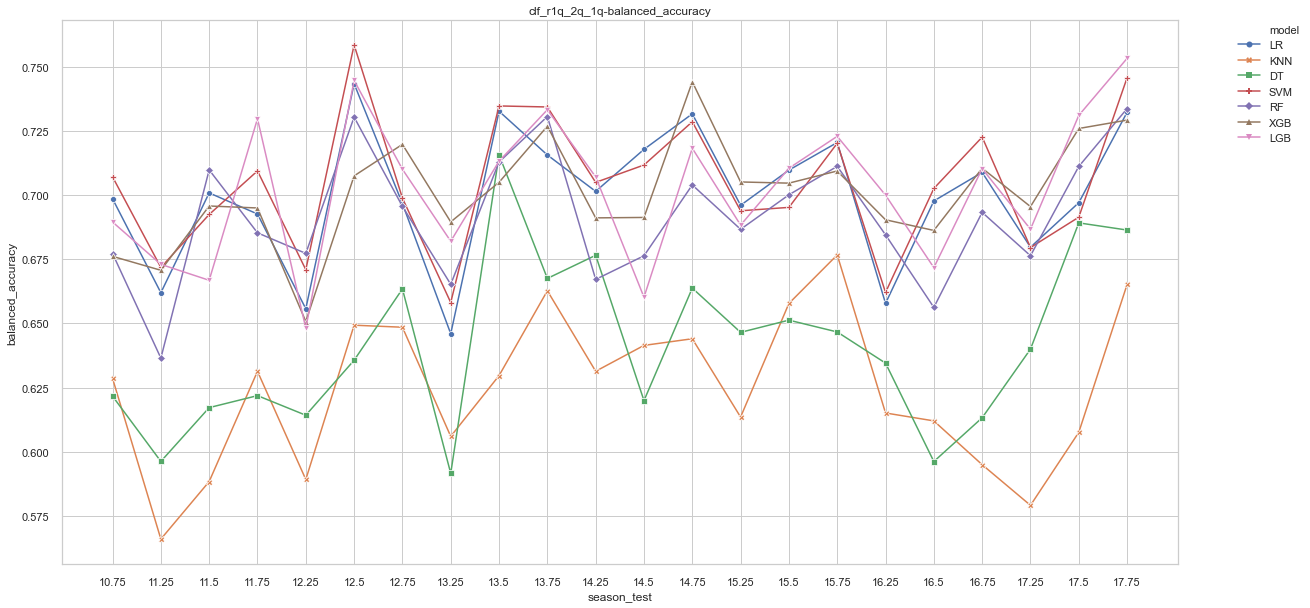

In [140]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(20,10))

### Experiments comparison

In [250]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [251]:
utils_exp.exp_results = utils.deserialize_object(exp_group_name)
exp_df = get_results_df()

In [252]:
ba_df = exp_df[['exp_name', 'model',
       'balanced_accuracy_mean', 'balanced_accuracy_std']]

In [253]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [244]:
ba_df.sort_values(
    by=["balanced_accuracy_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
0,clf_2_seasons_boruta_specific_3,LR,0.728800,0.014623
1,clf_2_seasons_boruta_specific,SVM,0.728522,0.014500
2,clf_2_seasons_boruta_specific_0,SVM,0.728522,0.014500
3,clf_2_seasons_boruta_specific_3,SVM,0.728416,0.012863
4,clf_2_seasons_boruta_specific_5,SVM,0.727680,0.015142
5,clf_2_seasons_boruta_specific,LR,0.727087,0.016150


### Plot experiment results

In [146]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### Balance Accuracy

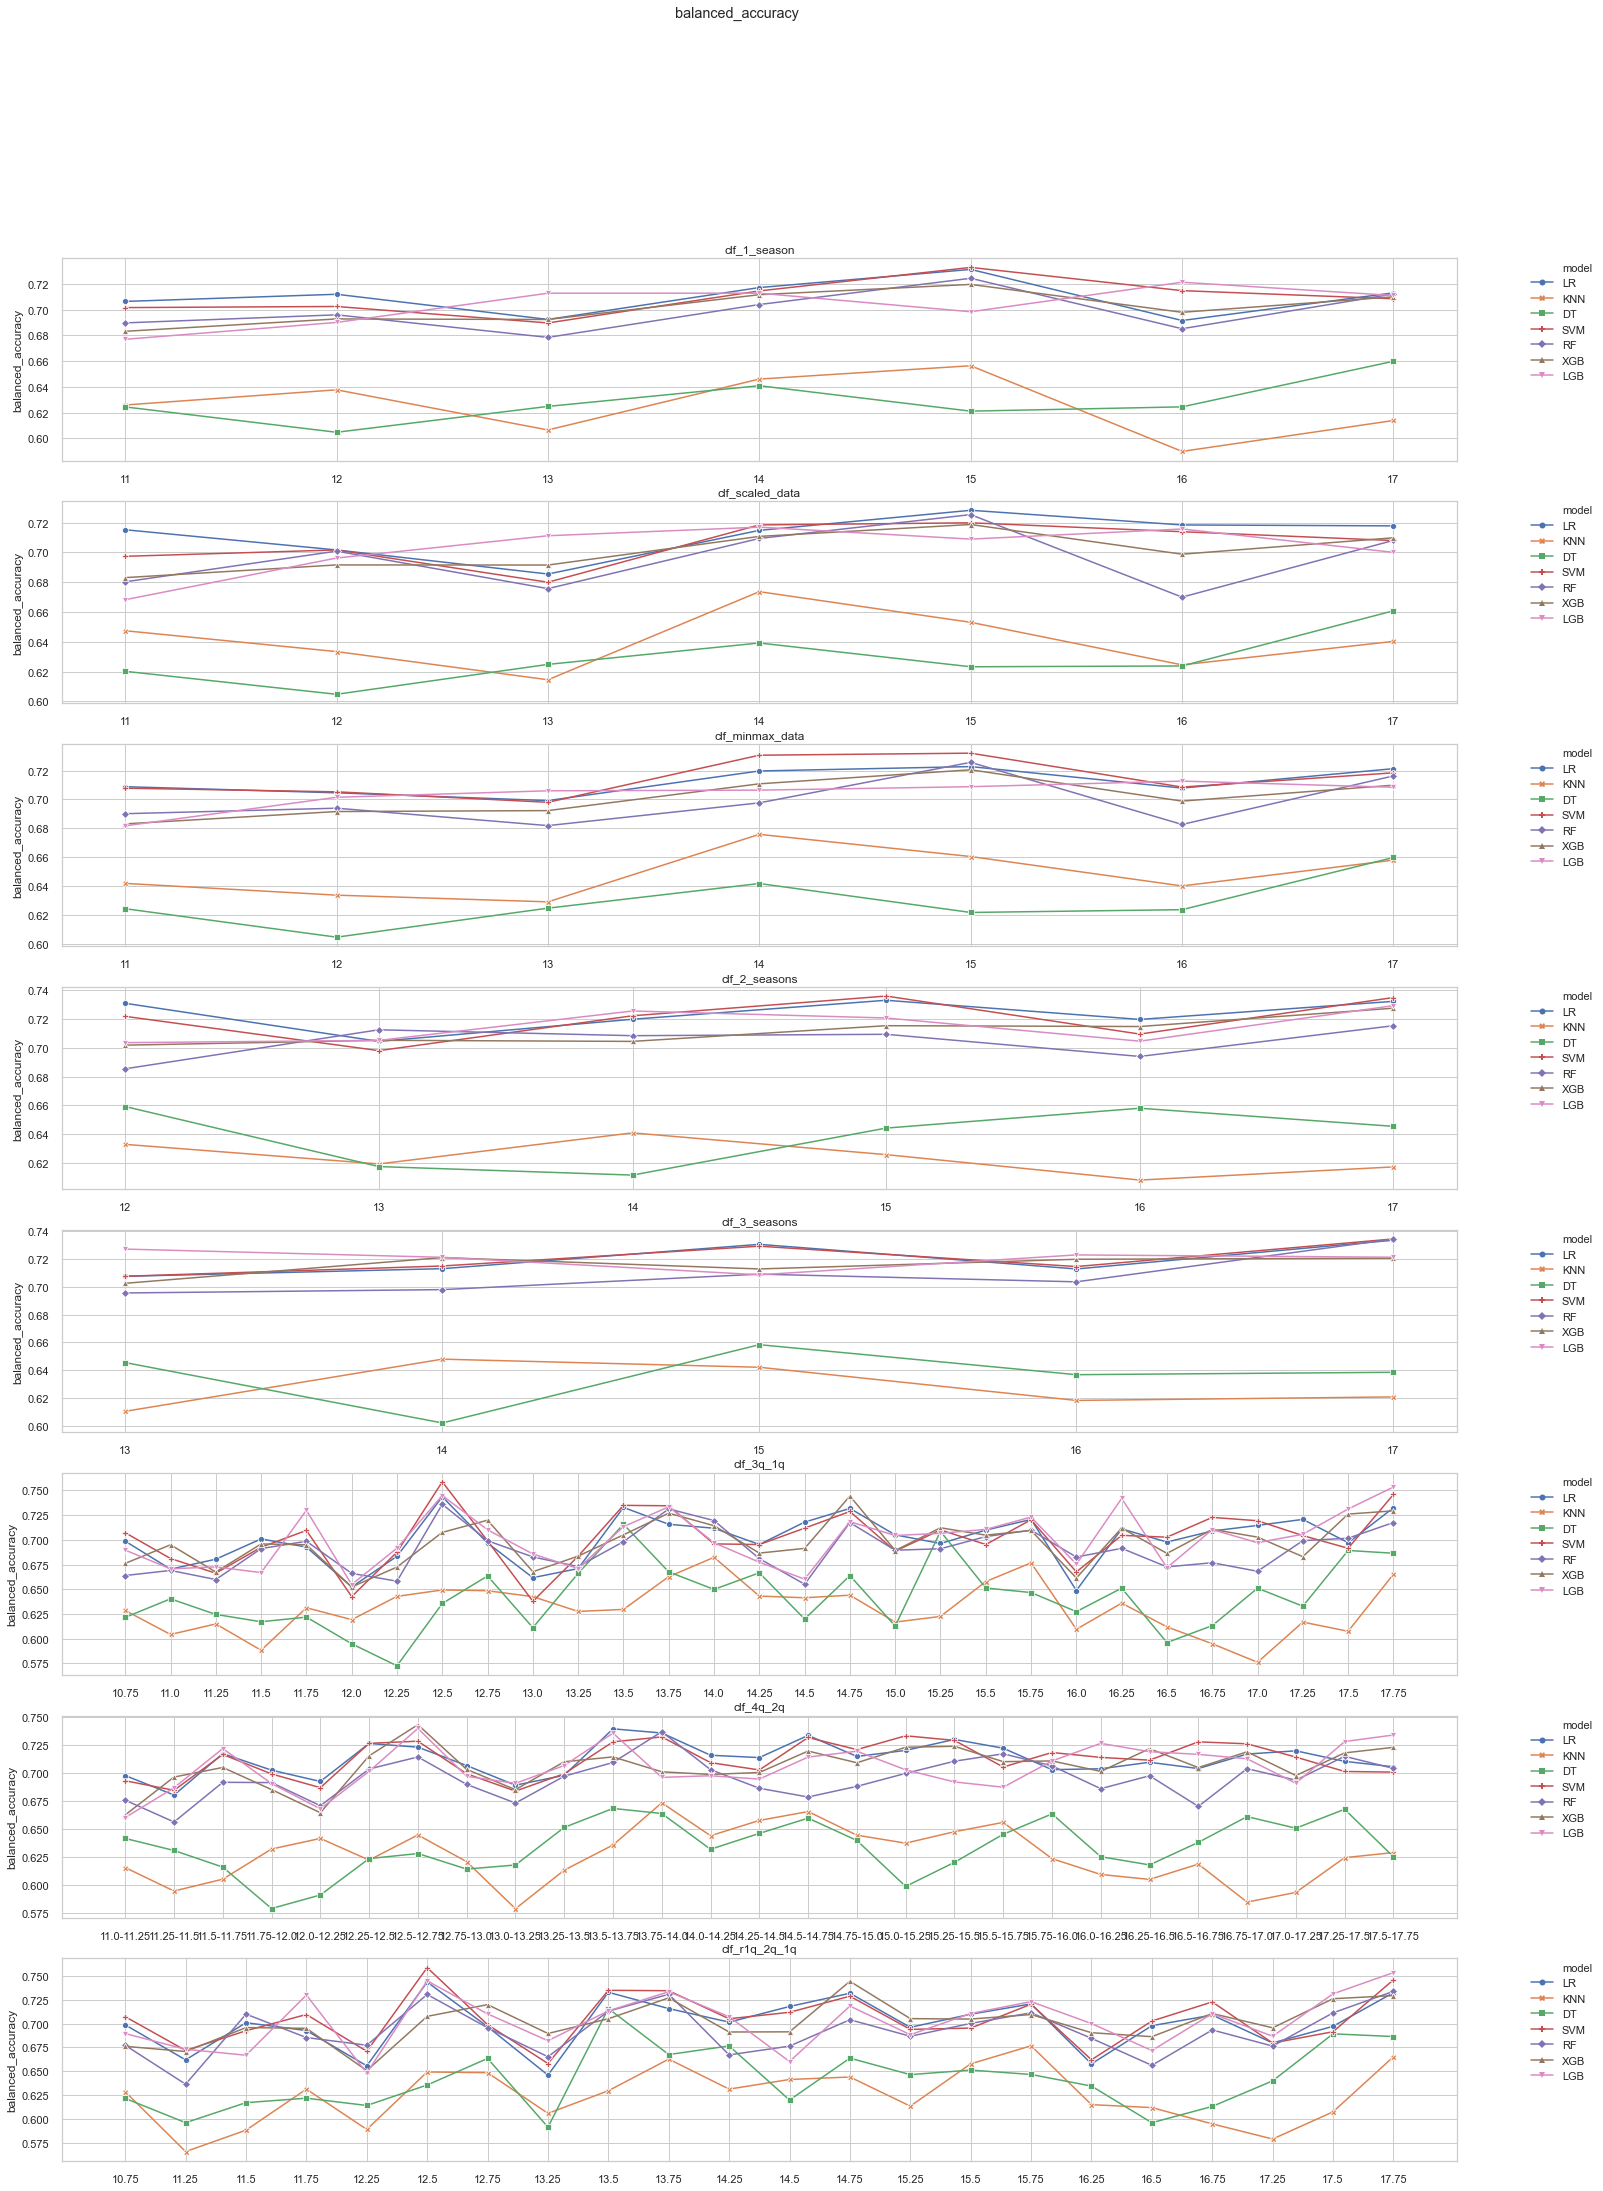

In [147]:
utils.plot_to_compare_experiments(
    results_total,
    metric="balanced_accuracy",
    figsize=(25, 35),
    use_pointplot=True
)

#### Precision

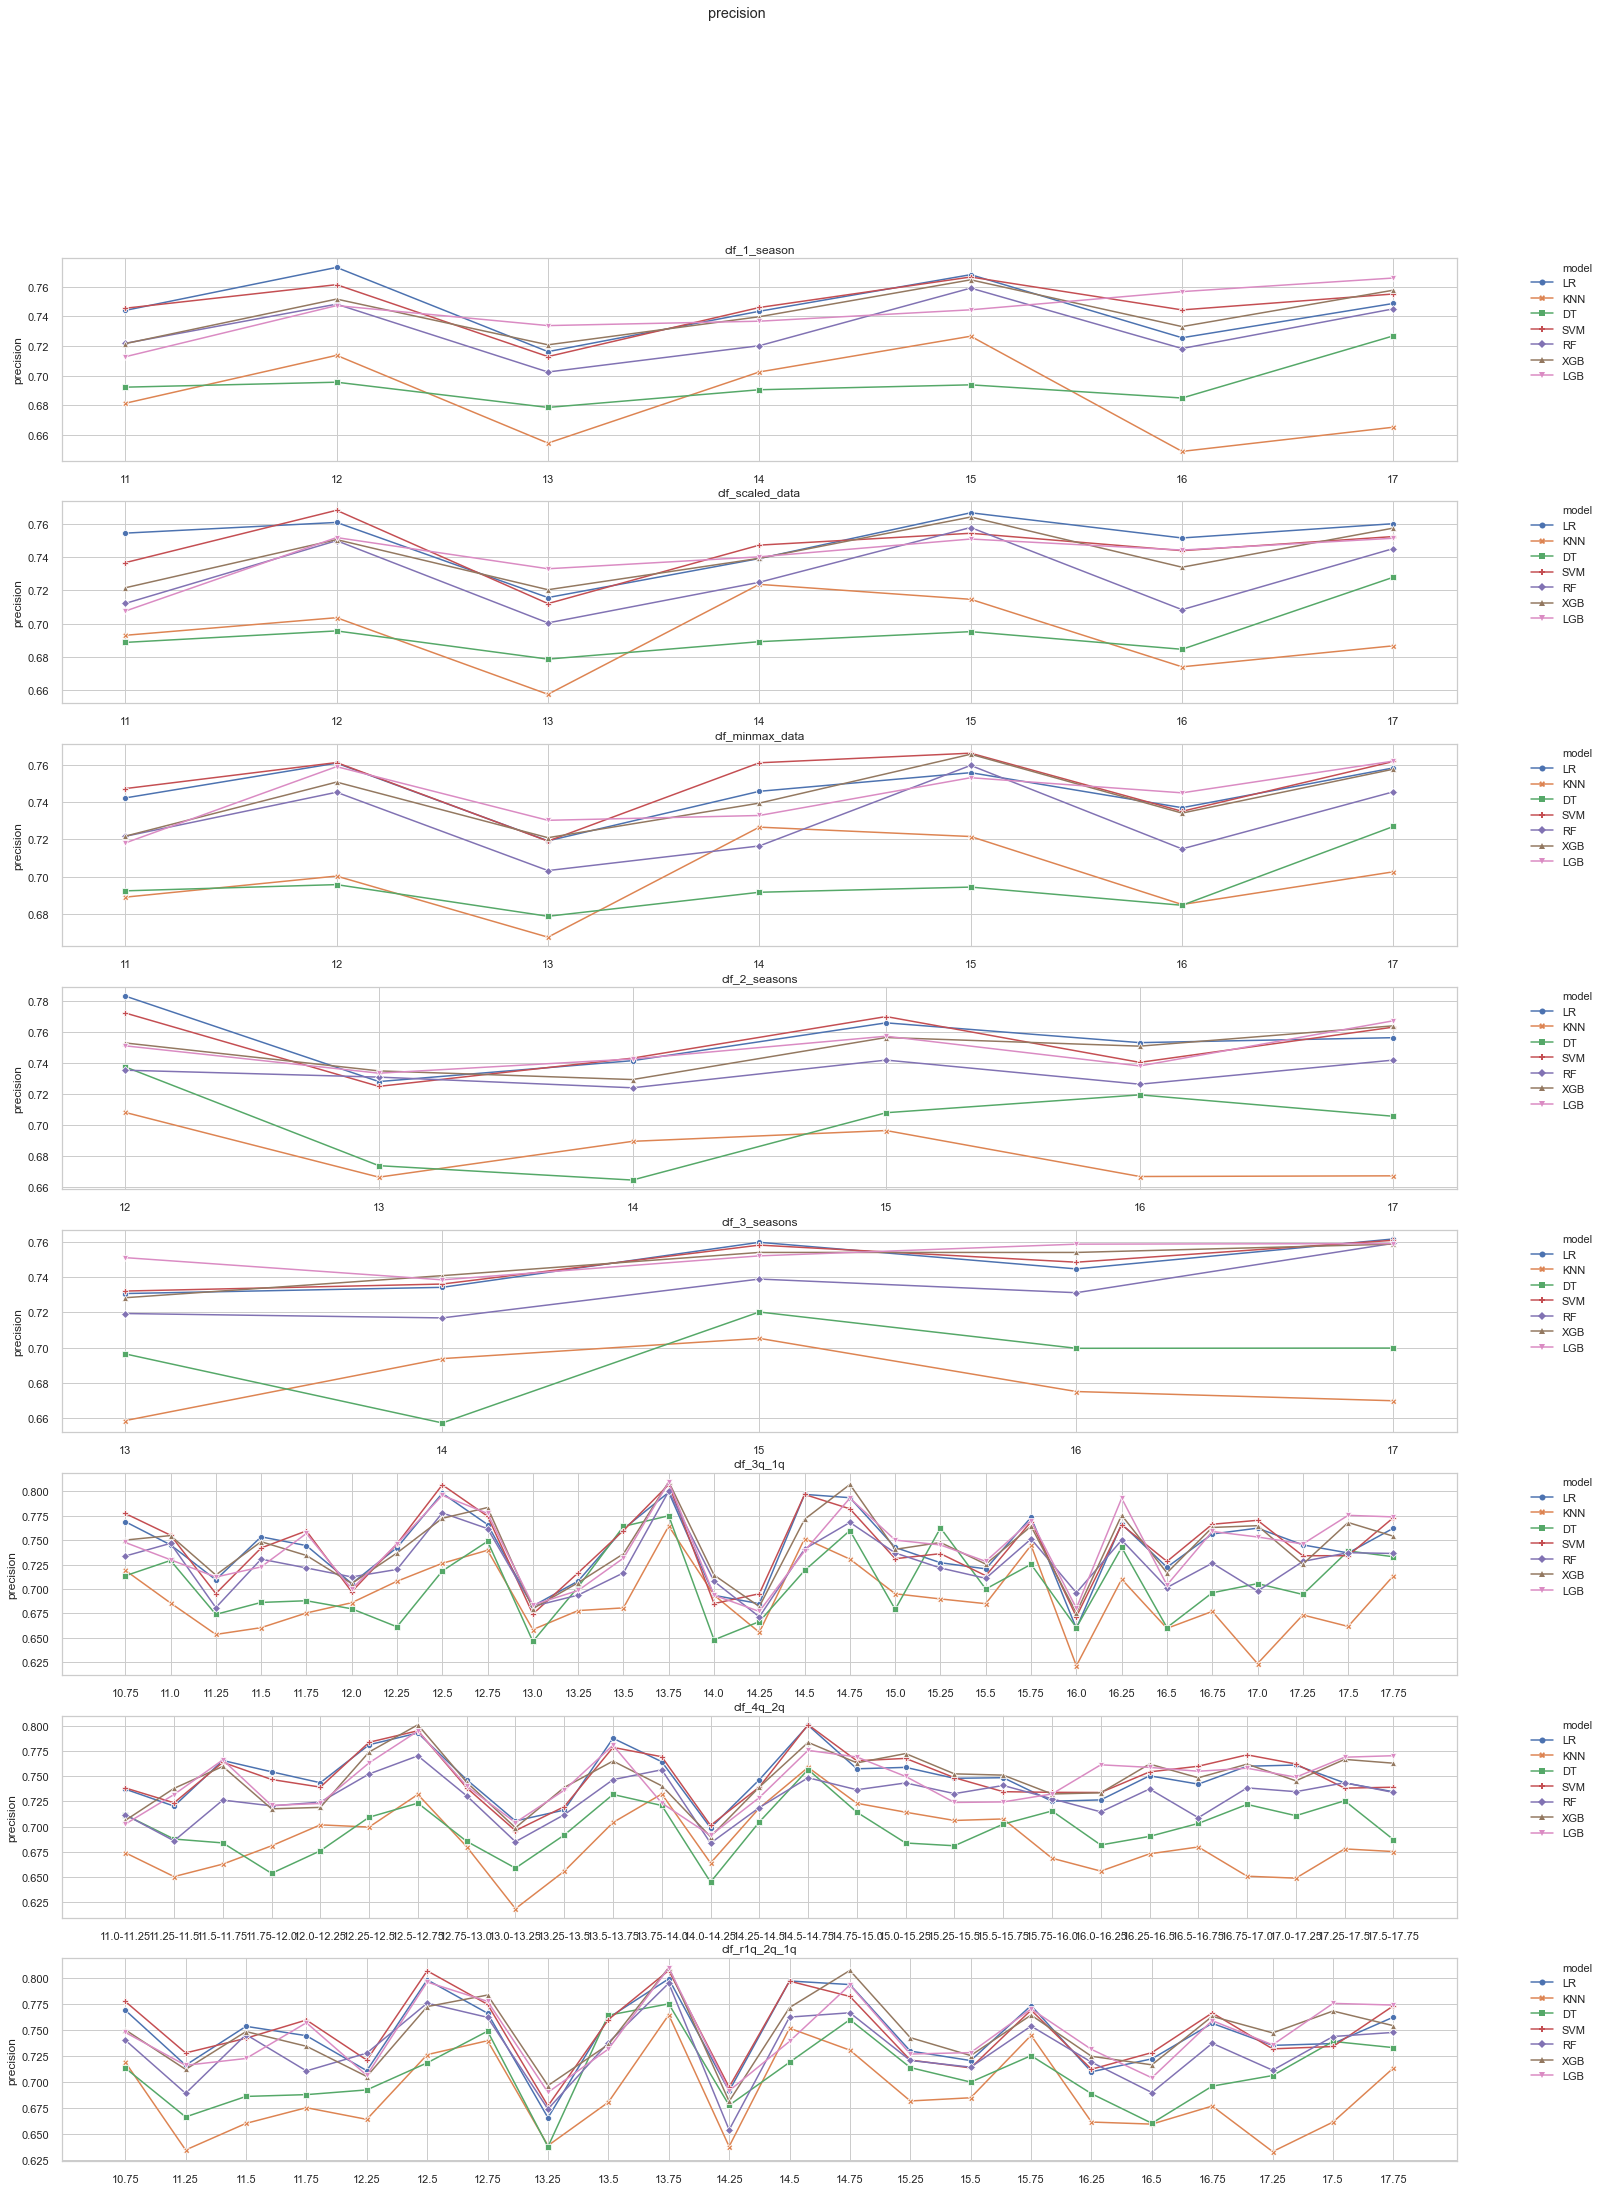

In [148]:
utils.plot_to_compare_experiments(
    results_total,
    metric="precision",
    figsize=(25, 35),
    use_pointplot=True
)

#### ROC AUC

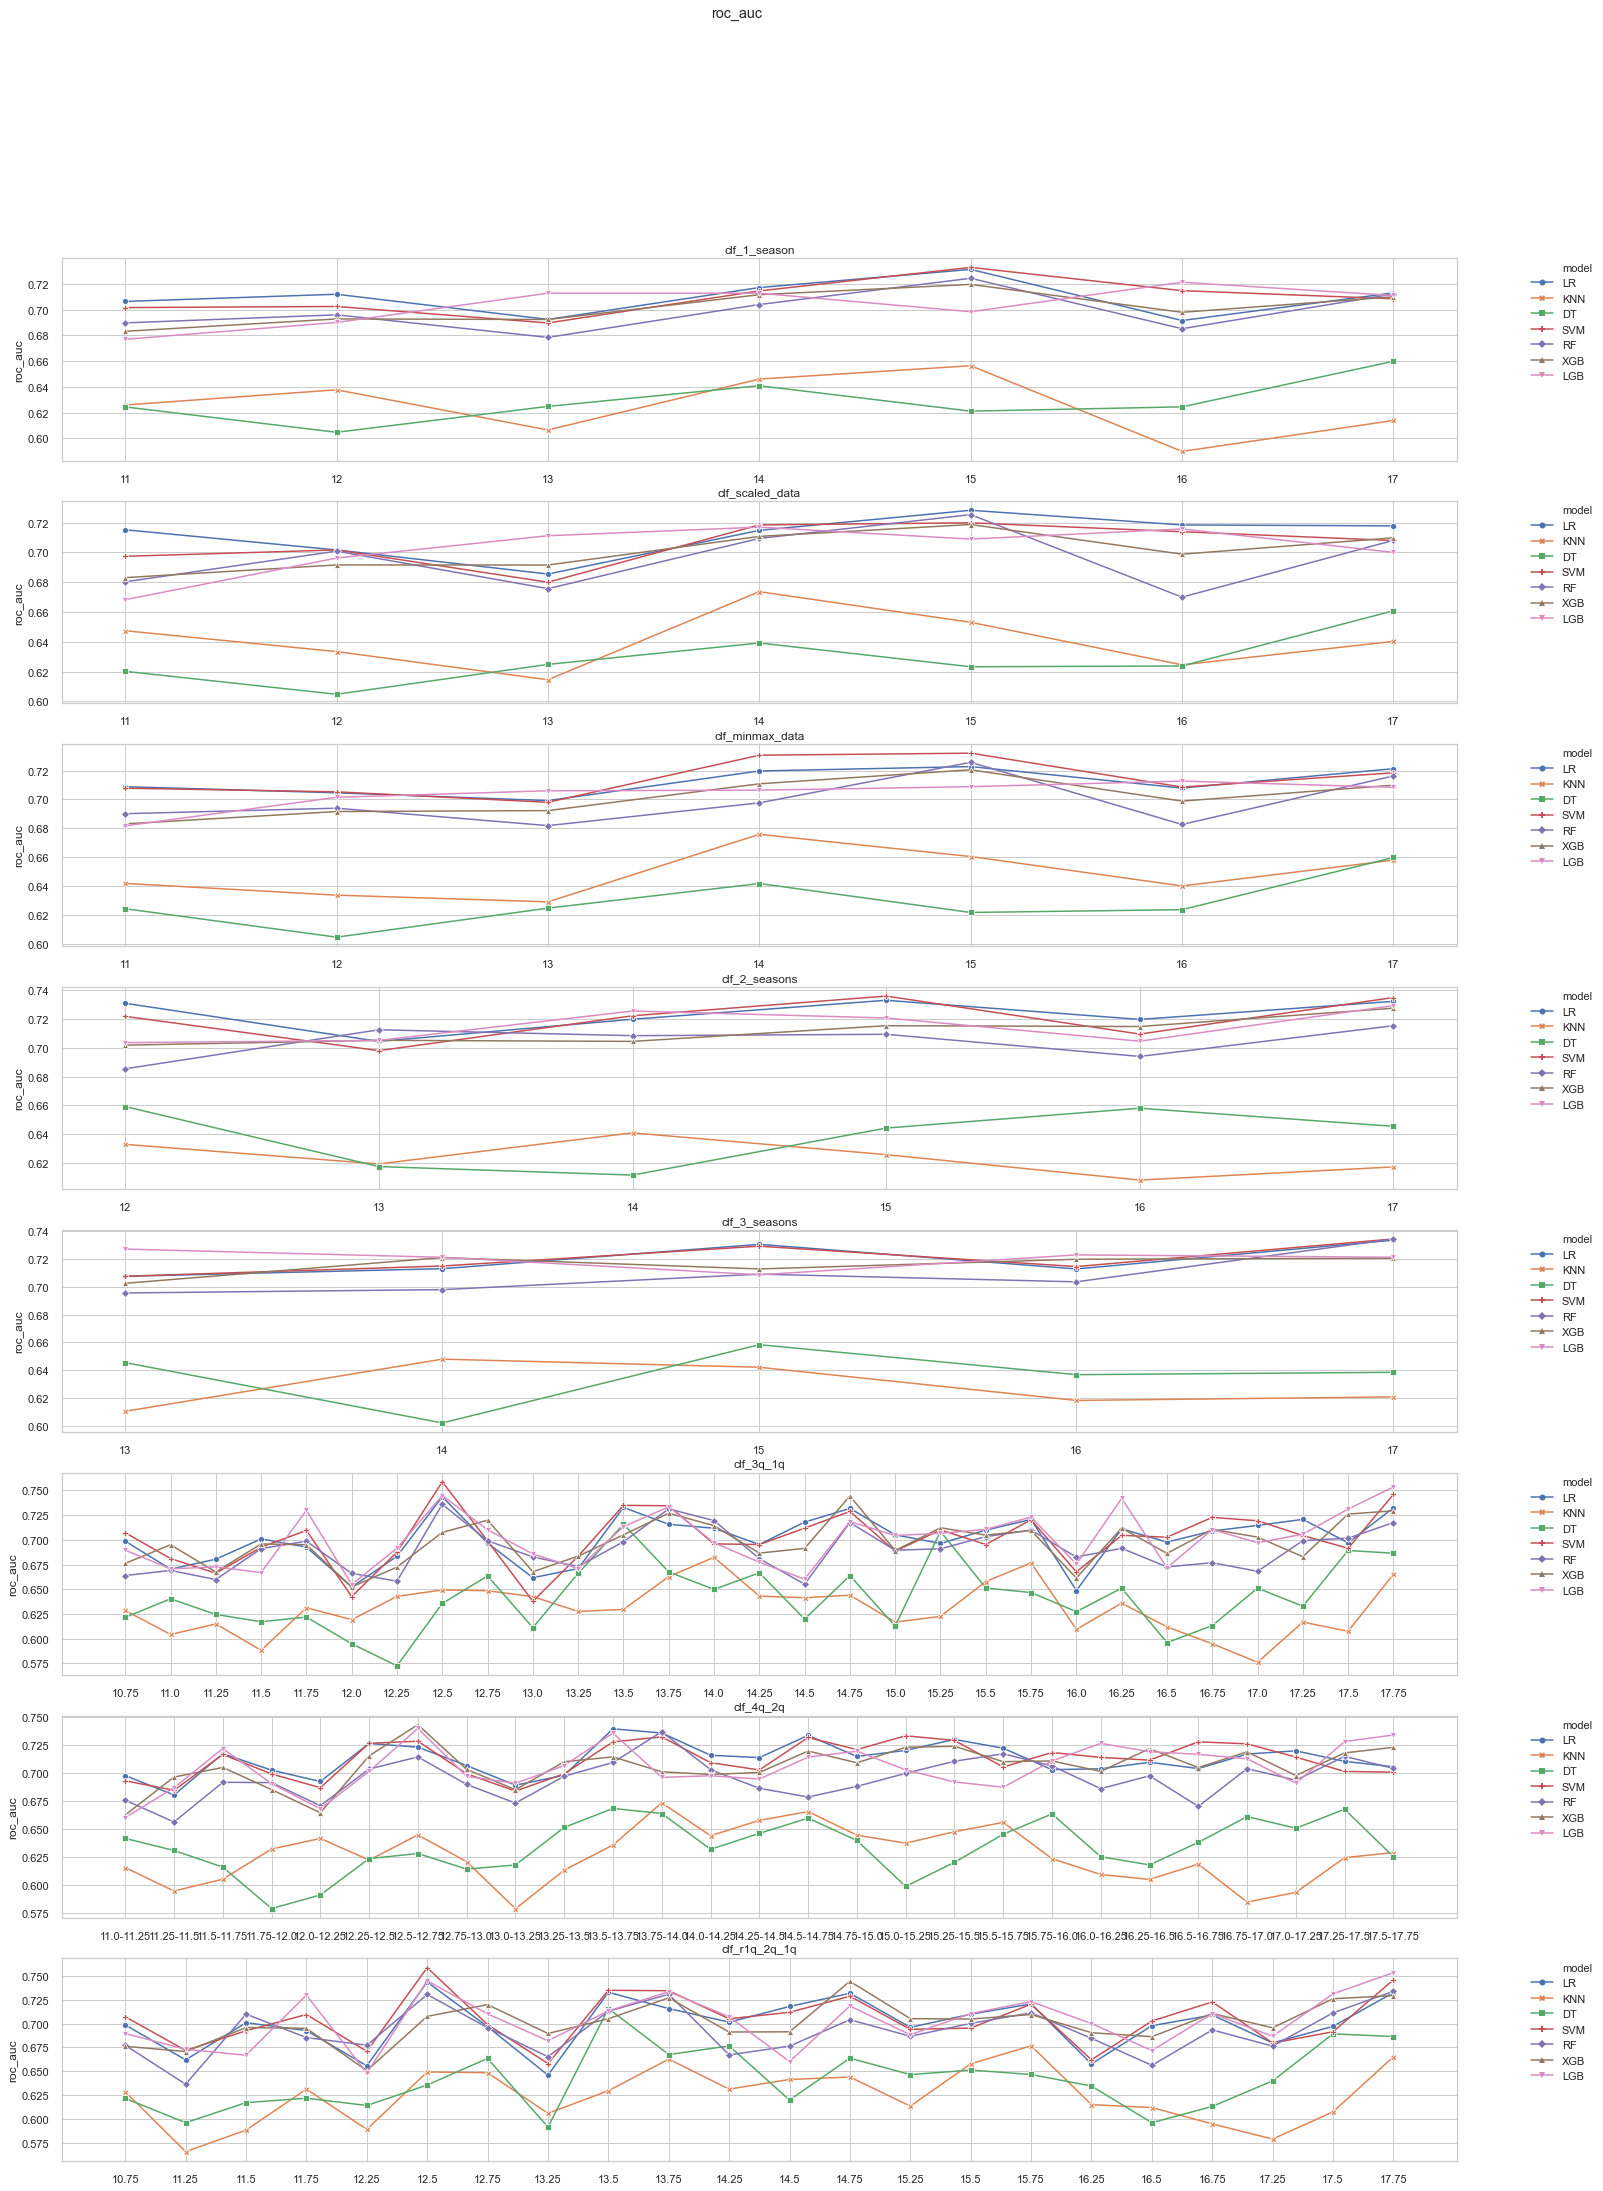

In [149]:
utils.plot_to_compare_experiments(
    results_total,
    metric="roc_auc",
    figsize=(25, 35),
    use_pointplot=True
)